In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from datetime import datetime as dt

In [228]:
la_df = pd.read_csv('2018-2022.csv')

#after adding last 30 days of data on Oct 26 had to drop overlapping entries in the csv file
#better to move this into crime data cleaning nbook later
la_df = la_df.drop_duplicates('LURN_SAK', ignore_index=True)
la_df.info()

#I will study crime intensity vs various time tags weekday, hour
#For convenience add year/hour/month/weekday as separate column in the dataframe

def add_time_intervals(df):
    df['timestamp'] = pd.to_datetime(df['INCIDENT_DATE'], format='%m/%d/%Y %I:%M:%S %p')
    df['date'] = df['timestamp'].dt.date
    df['year'] = df['timestamp'].dt.year
    df['hour'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month
    df['weekday'] = df['timestamp'].dt.isocalendar().day
    return df #modified df

cutoff_date = dt.strptime("2018-01-01", '%Y-%m-%d').date()
end_date = dt.strptime("2022-01-01", '%Y-%m-%d').date()
#save modified df's
la_df = add_time_intervals(la_df)

la_df_18_21 = la_df.query('date >= @cutoff_date and date < @end_date')
la_df_22 = la_df.query('date >= @end_date')



In [229]:
top_10_cities = la_df['CITY'].value_counts()
top_10_zip = la_df['ZIP'].value_counts()

In [230]:
top_10_cities = list(top_10_cities[:10].index)
top_10_cities

['LOS ANGELES',
 'LANCASTER',
 'COMPTON',
 'PALMDALE',
 'CARSON',
 'NORWALK',
 'LYNWOOD',
 'WEST HOLLYWOOD',
 'BELLFLOWER',
 'LAKEWOOD']

In [113]:
#crime per city per day 
crime_cnts_pivot = la_crime_cnts.pivot_table(values='LURN_SAK', index='date', columns =[ 'CITY'], aggfunc='count')
crime_cnts_pivot

CITY,BELLFLOWER,CARSON,COMPTON,LANCASTER,LOS ANGELES,LYNWOOD,NORWALK,PALMDALE,WEST HOLLYWOOD,WHITTIER
date,,,,,,,,,,
2018-01-01,6.0,10.0,34.0,29.0,59.0,9.0,11.0,26.0,13.0,8.0
2018-01-02,7.0,13.0,26.0,21.0,48.0,6.0,8.0,20.0,9.0,8.0
2018-01-03,10.0,10.0,24.0,32.0,45.0,8.0,16.0,18.0,12.0,16.0
2018-01-04,7.0,6.0,18.0,17.0,63.0,8.0,13.0,10.0,16.0,6.0
2018-01-05,8.0,10.0,27.0,17.0,49.0,5.0,6.0,14.0,10.0,5.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-27,6.0,11.0,11.0,14.0,37.0,12.0,3.0,20.0,6.0,3.0
2021-12-28,10.0,11.0,14.0,19.0,42.0,12.0,5.0,15.0,6.0,4.0
2021-12-29,8.0,8.0,19.0,23.0,26.0,5.0,6.0,14.0,5.0,10.0


In [231]:
la_crime_cnts_train = la_df_18_21[['LURN_SAK', 'CITY', 'ZIP', 'UNIT_NAME', 'date', 'year', 'hour', 'month', 'weekday']].query('CITY in @top_10_cities')
la_crime_cnts_test = la_df_22[['LURN_SAK', 'CITY', 'ZIP', 'UNIT_NAME', 'date', 'year', 'hour', 'month', 'weekday']].query('CITY in @top_10_cities')


def time_of_day(row):
    hour = row['hour']
    if hour <= 3:
        return 1 #late night
    if hour <= 7:
        return 2 #early morning
    if hour <= 11:
        return 3 #morning
    if hour <= 15:
        return 4 #midday
    if hour <= 19:
        return 5 #early evening
    return 6 #night

la_crime_cnts_train['hour_cat'] = la_crime_cnts_train.apply(time_of_day, axis=1)
la_crime_cnts_test['hour_cat'] = la_crime_cnts_test.apply(time_of_day, axis=1)

In [146]:
la_crime_cnts_test

,LURN_SAK,CITY,ZIP,UNIT_NAME,date,year,hour,month,weekday,hour_cat
505402,19984761,LOS ANGELES,90012.0,INMATE RECEPTION CENTR,2022-08-03,2022,13,8,3,4
505403,20012947,LOS ANGELES,90012.0,INMATE RECEPTION CENTR,2022-09-01,2022,22,9,4,6
505405,19896574,WHITTIER,90605.0,NORWALK,2022-04-27,2022,16,4,3,5
505406,19987375,PALMDALE,NaN,PALMDALE,2022-08-05,2022,23,8,5,6
505408,20009442,PALMDALE,93550.0,PALMDALE,2022-08-29,2022,15,8,1,4
...,...,...,...,...,...,...,...,...,...,...
602085,20021070,NORWALK,90650.0,NORWALK,2022-09-10,2022,18,9,6,5
602087,20025779,WHITTIER,90604.0,NORWALK,2022-09-14,2022,10,9,3,3
602088,20026398,WHITTIER,90604.0,NORWALK,2022-09-15,2022,0,9,4,1
602089,20029540,WHITTIER,NaN,NORWALK,2022-09-19,2022,0,9,1,1


In [337]:
#prepare train data - all from 2018-2021
la_train = (la_crime_cnts_train
            #.query('CITY == "LOS ANGELES"')
            .groupby(by=['date', 'year', 'month', 'weekday', 'hour_cat'], as_index=False)
            .agg({'LURN_SAK':'count'})
            .rename(columns={'LURN_SAK':'crime_count'})
            #pivot_table(values='LURN_SAK', columns =['year','hour_cat','weekday'], aggfunc='count')
            )
la_train

#prepare test data - year 2022
la_test = (la_crime_cnts_test
            #.query('CITY == "LOS ANGELES"')
            .groupby(by=['date', 'year', 'month', 'weekday', 'hour_cat'], as_index=False)
            .agg({'LURN_SAK':'count'})
            .rename(columns={'LURN_SAK':'crime_count'})
            #pivot_table(values='LURN_SAK', columns =['year','hour_cat','weekday'], aggfunc='count')
            )
la_test

,date,year,month,weekday,hour_cat,crime_count
0,2022-01-01,2022,1,6,1,40
1,2022-01-01,2022,1,6,2,16
2,2022-01-01,2022,1,6,3,30
3,2022-01-01,2022,1,6,4,22
4,2022-01-01,2022,1,6,5,27
...,...,...,...,...,...,...
1782,2022-10-25,2022,10,2,1,6
1783,2022-10-25,2022,10,2,3,3
1784,2022-10-25,2022,10,2,4,1
1785,2022-10-25,2022,10,2,5,1


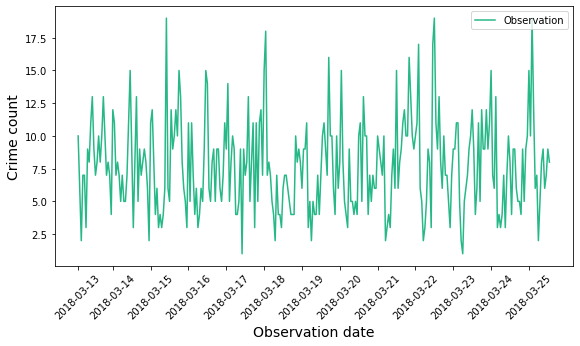

In [371]:

la_hourly = (la_crime_cnts_train
            #.query('CITY == "LOS ANGELES"')
            .groupby(by=['date', 'hour'], as_index=False)
            .agg({'LURN_SAK':'count'})
            .rename(columns={'LURN_SAK':'crime_count'})
            #pivot_table(values='LURN_SAK', columns =['year','hour_cat','weekday'], aggfunc='count')
            )
la_hourly.head()

ticklabels_hourly = la_hourly['date'][1700:2000].drop_duplicates()

plt.figure(figsize=(8,4))
plt.axes([0.1, 0.2, 0.9, 0.9])

plt.plot(la_hourly.index[1700:2000], la_hourly['crime_count'][1700:2000], label='Observation', color='#26B887')

plt.xticks(ticklabels_hourly.index, ticklabels_hourly, rotation=45)
plt.xlabel('Observation date', fontsize=14)
plt.ylabel('Crime count', fontsize=14)
plt.legend(loc='upper right')

plt.show()

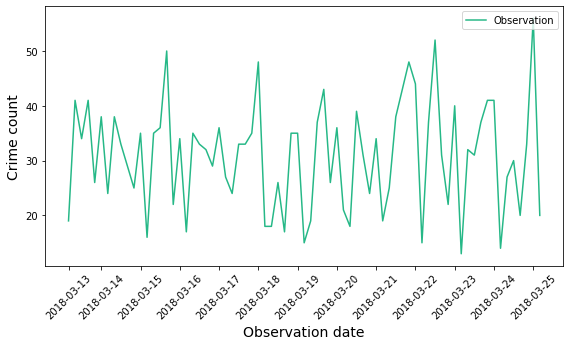

In [383]:
la_hourly = (la_crime_cnts_train
            #.query('CITY == "LOS ANGELES"')
            .groupby(by=['date', 'hour_cat'], as_index=False)
            .agg({'LURN_SAK':'count'})
            .rename(columns={'LURN_SAK':'crime_count'})
            #pivot_table(values='LURN_SAK', columns =['year','hour_cat','weekday'], aggfunc='count')
            )
la_hourly.head()

ticklabels_hourly = la_hourly['date'][427:500].drop_duplicates()

plt.figure(figsize=(8,4))
plt.axes([0.1, 0.2, 0.9, 0.9])

plt.plot(la_hourly.index[427:500], la_hourly['crime_count'][427:500], label='Observation', color='#26B887')

plt.xticks(ticklabels_hourly.index, ticklabels_hourly, rotation=45)
plt.xlabel('Observation date', fontsize=14)
plt.ylabel('Crime count', fontsize=14)
plt.legend(loc='upper right')

plt.show()

In [179]:
import scipy.fft

fft = scipy.fft.fft((pivot_la.LURN_SAK - pivot_la.LURN_SAK.mean()).values)
plt.plot(np.abs(fft))
plt.title("FFT of crime data")
plt.xlim([0,700])
plt.xlabel('# Cycles in full window of data (~4 years)');

AttributeError: 'DataFrame' object has no attribute 'LURN_SAK'

Text(0.5, 0, 'Frequency ($y^{-1}$)')

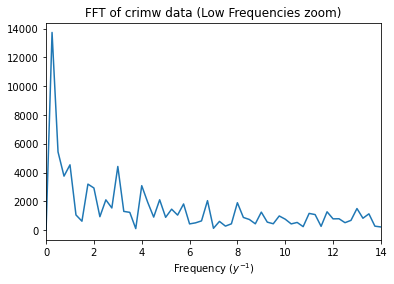

In [99]:
plt.plot(1./4 * np.arange(len(fft)), np.abs(fft))
plt.title("FFT of crime data (Low Frequencies zoom)")
plt.xlim([0,14])
plt.xlabel('Frequency ($y^{-1}$)')

In [282]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression
from sklearn.neighbors import KNeighborsClassifier


In [222]:
la_df = pd.read_csv('2018-2022.csv')
la_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 610477 entries, 0 to 610476
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     610477 non-null  int64  
 1   LURN_SAK       610477 non-null  int64  
 2   INCIDENT_DATE  610477 non-null  object 
 3   CATEGORY       610477 non-null  object 
 4   STAT           610477 non-null  int64  
 5   ADDRESS        601941 non-null  object 
 6   LONGITUDE      580207 non-null  float64
 7   LATITUDE       580207 non-null  float64
 8   PART_CATEGORY  610477 non-null  int64  
 9   CITY           601941 non-null  object 
 10  ZIP            352708 non-null  float64
 11  UNIT_NAME      610477 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 55.9+ MB


In [195]:
#will need to modify to put in dataframe groupby with crime counts as above
class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        times = pd.DatetimeIndex(X['time'])
        hour = times.hour
        month = times.month
        return pd.DataFrame({'hour': hour,
                            'month': month
                            })


In [338]:
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

#need to pass df with columns hour_cat, weekday, possibly month
crime_pipeline = Pipeline([
    ('encode', ColumnTransformer([("one_hot_time", one_hot_encoder, ["hour_cat", "weekday", "month"])])),    
    ('regressor', RidgeCV())
]) 


In [339]:

crime_pipeline.fit(la_train, la_train['crime_count'])
crime_pipeline.score(la_train, la_train['crime_count'])

0.423950618562724

In [323]:
len(la_test)

1787

In [340]:
crime_pipeline.score(la_test[:1070], la_test['crime_count'][:1070])

0.31062505491877535

In [341]:
la_test['predict'] = crime_pipeline.predict(la_test).astype('int')
la_test.sort_values(by= ['date', 'hour_cat'], inplace = True)
la_test.head(10)

,date,year,month,weekday,hour_cat,crime_count,predict
0,2022-01-01,2022,1,6,1,40,32
1,2022-01-01,2022,1,6,2,16,17
2,2022-01-01,2022,1,6,3,30,25
3,2022-01-01,2022,1,6,4,22,32
4,2022-01-01,2022,1,6,5,27,33
5,2022-01-01,2022,1,6,6,24,31
6,2022-01-02,2022,1,7,1,32,33
7,2022-01-02,2022,1,7,2,18,18
8,2022-01-02,2022,1,7,3,15,26
9,2022-01-02,2022,1,7,4,20,32


In [259]:
ticklabels = la_test['date'].drop_duplicates()
ticklabels

0       2022-01-01
6       2022-01-02
12      2022-01-03
18      2022-01-04
24      2022-01-05
           ...    
1764    2022-10-22
1770    2022-10-23
1776    2022-10-24
1782    2022-10-25
1786    2022-10-26
Name: date, Length: 299, dtype: object

In [348]:
from matplotlib.widgets import Slider

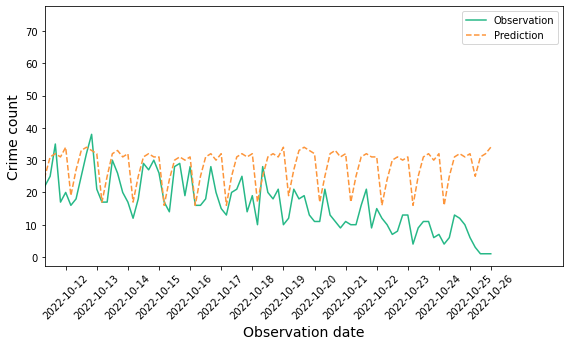

In [363]:
ticklabels = la_test['date'].drop_duplicates()

plt.figure(figsize=(8,4))
plt.axes([0.1, 0.2, 0.9, 0.9])

plt.plot(la_test.index, la_test['crime_count'], label='Observation', color='#26B887')
plt.plot(la_test.index, la_test['predict'], label='Prediction', linestyle='--', color='#FD953A')
#plt.title("FFT of crime data (Low Frequencies zoom)")

plt.xticks(ticklabels.index, ticklabels, rotation=45)
plt.xlabel('Observation date', fontsize=14)
plt.ylabel('Crime count', fontsize=14)
plt.legend(loc='upper right')


 
# Call update function when slider value is changed
plt.xlim([1700,1800])
#plt.xlabel('Frequency ($y^{-1}$)')
plt.show()



In [304]:
#what about per day per city predictions: features - weekday, month
la_daily_train = (la_crime_cnts_train
            .query('CITY == "LOS ANGELES"')
            .groupby(by=['date', 'year', 'month', 'weekday'], as_index=False)
            .agg({'LURN_SAK':'count'})
            .rename(columns={'LURN_SAK':'crime_count'})
            #pivot_table(values='LURN_SAK', columns =['year','hour_cat','weekday'], aggfunc='count')
            )



la_daily_test = (la_crime_cnts_test
            .query('CITY == "LOS ANGELES"')
            .groupby(by=['date', 'year', 'month', 'weekday'], as_index=False)
            .agg({'LURN_SAK':'count'})
            .rename(columns={'LURN_SAK':'crime_count'})
            #pivot_table(values='LURN_SAK', columns =['year','hour_cat','weekday'], aggfunc='count')
            )
la_daily_test

,date,year,month,weekday,crime_count
0,2022-01-01,2022,1,6,47
1,2022-01-02,2022,1,7,36
2,2022-01-03,2022,1,1,37
3,2022-01-04,2022,1,2,38
4,2022-01-05,2022,1,3,33
...,...,...,...,...,...
293,2022-10-21,2022,10,5,21
294,2022-10-22,2022,10,6,10
295,2022-10-23,2022,10,7,11
296,2022-10-24,2022,10,1,13


In [305]:
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

#need to pass df with columns hour_cat, weekday, possibly month
crime_pipeline_daily = Pipeline([
    ('encode', ColumnTransformer([("one_hot_time", one_hot_encoder, ["weekday", "month"])])),    
    ('regressor', ())
]) 

crime_pipeline_daily.fit(la_daily_train, la_daily_train['crime_count'])
crime_pipeline_daily.score(la_daily_train, la_daily_train['crime_count'])

0.11611969402351208

In [306]:
la_daily_test['predict'] = crime_pipeline_daily.predict(la_daily_test).astype('int')
la_daily_test



,date,year,month,weekday,crime_count,predict
0,2022-01-01,2022,1,6,47,47
1,2022-01-02,2022,1,7,36,48
2,2022-01-03,2022,1,1,37,50
3,2022-01-04,2022,1,2,38,51
4,2022-01-05,2022,1,3,33,54
...,...,...,...,...,...,...
293,2022-10-21,2022,10,5,21,46
294,2022-10-22,2022,10,6,10,44
295,2022-10-23,2022,10,7,11,45
296,2022-10-24,2022,10,1,13,46


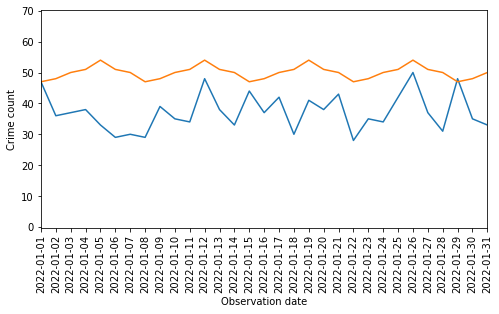

In [310]:
ticklabels_daily = la_daily_test['date']

plt.figure(figsize=(8,4))
plt.plot(la_daily_test.index, la_daily_test['crime_count'])
plt.plot(la_daily_test.index, la_daily_test['predict'])
#plt.title("FFT of crime data (Low Frequencies zoom)")

plt.xticks(ticklabels_daily.index, ticklabels_daily, rotation='vertical')
plt.xlabel('Observation date')
plt.ylabel('Crime count')
plt.xlim([0,30])
#plt.xlabel('Frequency ($y^{-1}$)')
plt.show()